In [1]:
# Cell 1: Imports and Setup
import sys
from pathlib import Path

# Add parent directory to path
project_root = Path.cwd().parent if "notebooks" in str(Path.cwd()) else Path.cwd()
sys.path.insert(0, str(project_root))

import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

from tvbingefriend_recommendation_service.services.data_loader_service import ShowDataLoader

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("✓ Imports successful")

✓ Imports successful


In [2]:
# Cell 2: Load data
loader = ShowDataLoader()

print("Fetching all shows...")
shows = loader.get_all_shows(batch_size=1000, max_shows=None)

df = pd.DataFrame(shows)
print(f"✓ Loaded {len(df)} shows")
print(f"Columns: {df.columns.tolist()}")

Fetching all shows...
✓ Loaded 100 shows
Columns: ['id', 'url', 'name', 'type', 'language', 'genres', 'status', 'runtime', 'averageRuntime', 'premiered', 'ended', 'officialSite', 'schedule', 'rating', 'weight', 'network', 'webchannel', 'dvdCountry', 'externals', 'image', 'summary', 'updated', '_links']


In [3]:
# Cell 3: Extract and clean fields

# Extract rating
df["rating_avg"] = df["rating"].apply(lambda x: x.get("average") if isinstance(x, dict) else None)

# Extract network/platform
df["network_name"] = df["network"].apply(lambda x: x.get("name") if isinstance(x, dict) else None)
df["webchannel_name"] = df["webchannel"].apply(
    lambda x: x.get("name") if isinstance(x, dict) else None
)
df["platform"] = df["network_name"].fillna(df["webchannel_name"])

# Keep essential columns
df_clean = df[
    ["id", "name", "genres", "summary", "type", "language", "status", "platform", "rating_avg"]
].copy()

print("Cleaned DataFrame shape:", df_clean.shape)
print("\nSample row:")
print(df_clean.iloc[0])

Cleaned DataFrame shape: (100, 9)

Sample row:
id                                                            1
name                                             Under the Dome
genres                       [Drama, Science-Fiction, Thriller]
summary       <p><b>Under the Dome</b> is the story of a sma...
type                                                   Scripted
language                                                English
status                                                    Ended
platform                                                    CBS
rating_avg                                                  6.5
Name: 0, dtype: object


In [4]:
# Cell 4: Text Preprocessing - Clean HTML from summaries


def clean_html(text):
    """Remove HTML tags from text"""
    if pd.isna(text):
        return ""

    # Remove HTML tags
    text = re.sub(r"<[^>]+>", "", str(text))

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text)

    return text.strip()


# Clean summaries
df_clean["summary_clean"] = df_clean["summary"].apply(clean_html)

print("Example cleaned summary:")
print("\nOriginal:")
print(df_clean.iloc[0]["summary"][:200])
print("\nCleaned:")
print(df_clean.iloc[0]["summary_clean"][:200])

Example cleaned summary:

Original:
<p><b>Under the Dome</b> is the story of a small town that is suddenly and inexplicably sealed off from the rest of the world by an enormous transparent dome. The town's inhabitants must deal with sur

Cleaned:
Under the Dome is the story of a small town that is suddenly and inexplicably sealed off from the rest of the world by an enormous transparent dome. The town's inhabitants must deal with surviving the


In [5]:
# Cell 5: Genre Features - Multi-hot encoding

print("=" * 50)
print("GENRE FEATURES")
print("=" * 50)

# Use MultiLabelBinarizer for multi-hot encoding
mlb_genres = MultiLabelBinarizer()
genre_features = mlb_genres.fit_transform(df_clean["genres"])

# Convert to DataFrame
df_genre_features = pd.DataFrame(genre_features, columns=mlb_genres.classes_, index=df_clean.index)

print(f"Genre feature matrix shape: {df_genre_features.shape}")
print(f"Number of unique genres: {len(mlb_genres.classes_)}")
print(f"\nGenres: {list(mlb_genres.classes_)}")
print(f"\nExample (first show '{df_clean.iloc[0]['name']}'):")
print(f"Genres: {df_clean.iloc[0]['genres']}")
print(f"Encoded: {df_genre_features.iloc[0].values}")

GENRE FEATURES
Genre feature matrix shape: (100, 20)
Number of unique genres: 20

Genres: ['Action', 'Adventure', 'Anime', 'Comedy', 'Crime', 'Drama', 'Espionage', 'Family', 'Fantasy', 'History', 'Horror', 'Legal', 'Medical', 'Music', 'Mystery', 'Romance', 'Science-Fiction', 'Supernatural', 'Thriller', 'Western']

Example (first show 'Under the Dome'):
Genres: ['Drama', 'Science-Fiction', 'Thriller']
Encoded: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0]


In [6]:
# Cell 6: Text Features - TF-IDF on summaries

print("=" * 50)
print("TEXT FEATURES (TF-IDF)")
print("=" * 50)

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=500,  # Limit to top 500 terms
    min_df=2,  # Term must appear in at least 2 documents
    max_df=0.8,  # Term must appear in less than 80% of documents
    stop_words="english",
    ngram_range=(1, 2),  # Unigrams and bigrams
    strip_accents="unicode",
)

# Fit and transform summaries
text_features = tfidf.fit_transform(df_clean["summary_clean"])

print(f"Text feature matrix shape: {text_features.shape}")
print(f"Number of terms: {len(tfidf.get_feature_names_out())}")
print(
    f"Matrix sparsity: {(1 - text_features.nnz / (text_features.shape[0] * text_features.shape[1])) * 100:.2f}%"
)

# Show top terms
feature_names = tfidf.get_feature_names_out()
print(f"\nSample terms (first 30): {list(feature_names[:30])}")

TEXT FEATURES (TF-IDF)
Text feature matrix shape: (100, 500)
Number of terms: 500
Matrix sparsity: 95.93%

Sample terms (first 30): ['100', '13', 'ability', 'acclaimed', 'act', 'actions', 'actors', 'adventure', 'adventures', 'afraid', 'age', 'agent', 'agents', 'ago', 'al', 'alive', 'alucard', 'america', 'american', 'ancient', 'anime', 'answers', 'anthology', 'anti', 'apocalyptic', 'apparently', 'apply', 'appointed', 'apprentice', 'armed']


In [7]:
# Cell 7: Examine TF-IDF results for a specific show

show_idx = 0  # First show
show_name = df_clean.iloc[show_idx]["name"]

# Get TF-IDF scores for this show
show_tfidf = text_features[show_idx].toarray()[0]

# Get top terms
top_term_indices = np.argsort(show_tfidf)[-10:][::-1]
top_terms = [(feature_names[i], show_tfidf[i]) for i in top_term_indices if show_tfidf[i] > 0]

print(f"Top terms for '{show_name}':")
for term, score in top_terms:
    print(f"  {term}: {score:.4f}")

Top terms for 'Under the Dome':
  town: 0.4482
  sealed: 0.3233
  apocalyptic: 0.3233
  rest world: 0.3233
  rest: 0.3027
  answers: 0.3027
  away: 0.2868
  small town: 0.2868
  small: 0.2531
  story: 0.2081


In [8]:
# Cell 8: Platform/Network Features - One-hot encoding

print("=" * 50)
print("PLATFORM FEATURES")
print("=" * 50)

# Get top N platforms (to avoid too many features)
TOP_N_PLATFORMS = 20

platform_counts = df_clean["platform"].value_counts()
top_platforms = platform_counts.head(TOP_N_PLATFORMS).index.tolist()

print(f"Total unique platforms: {df_clean['platform'].nunique()}")
print(f"Using top {TOP_N_PLATFORMS} platforms")
print(f"\nTop platforms: {top_platforms[:10]}...")

# Create binary features for top platforms
df_platform_features = pd.DataFrame(index=df_clean.index)
for platform in top_platforms:
    df_platform_features[f"platform_{platform}"] = (df_clean["platform"] == platform).astype(int)

# Add "other" category
df_platform_features["platform_other"] = (~df_clean["platform"].isin(top_platforms)).astype(int)

print(f"\nPlatform feature matrix shape: {df_platform_features.shape}")

PLATFORM FEATURES
Total unique platforms: 26
Using top 20 platforms

Top platforms: ['ABC', 'CBS', 'NBC', 'FOX', 'The CW', 'FX', 'HBO', 'Syfy', 'Paramount+ with Showtime', 'TNT']...

Platform feature matrix shape: (100, 21)


In [9]:
# Cell 9: Type Features - One-hot encoding

print("=" * 50)
print("TYPE FEATURES")
print("=" * 50)

type_counts = df_clean["type"].value_counts()
print("Show types:")
print(type_counts)

# One-hot encode type
df_type_features = pd.get_dummies(df_clean["type"], prefix="type")

print(f"\nType feature matrix shape: {df_type_features.shape}")
print(f"Type columns: {df_type_features.columns.tolist()}")

TYPE FEATURES
Show types:
type
Scripted     89
Animation     6
Reality       5
Name: count, dtype: int64

Type feature matrix shape: (100, 3)
Type columns: ['type_Animation', 'type_Reality', 'type_Scripted']


In [10]:
# Cell 10: Language Features - One-hot encoding (top languages only)

print("=" * 50)
print("LANGUAGE FEATURES")
print("=" * 50)

TOP_N_LANGUAGES = 5

language_counts = df_clean["language"].value_counts()
top_languages = language_counts.head(TOP_N_LANGUAGES).index.tolist()

print(f"Total unique languages: {df_clean['language'].nunique()}")
print(f"Using top {TOP_N_LANGUAGES} languages: {top_languages}")

# Create binary features for top languages
df_language_features = pd.DataFrame(index=df_clean.index)
for language in top_languages:
    df_language_features[f"lang_{language}"] = (df_clean["language"] == language).astype(int)

df_language_features["lang_other"] = (~df_clean["language"].isin(top_languages)).astype(int)

print(f"\nLanguage feature matrix shape: {df_language_features.shape}")

LANGUAGE FEATURES
Total unique languages: 2
Using top 5 languages: ['English', 'Japanese']

Language feature matrix shape: (100, 3)


In [11]:
# Cell 11: Combine all features into feature groups

print("=" * 50)
print("FEATURE SUMMARY")
print("=" * 50)

# Convert TF-IDF sparse matrix to dense for easier handling
# (We'll keep it sparse in production for memory efficiency)
text_features_dense = text_features.toarray()

print("Feature group shapes:")
print(f"  Genre features: {df_genre_features.shape}")
print(f"  Text features: {text_features_dense.shape}")
print(f"  Platform features: {df_platform_features.shape}")
print(f"  Type features: {df_type_features.shape}")
print(f"  Language features: {df_language_features.shape}")

total_features = (
    df_genre_features.shape[1]
    + text_features_dense.shape[1]
    + df_platform_features.shape[1]
    + df_type_features.shape[1]
    + df_language_features.shape[1]
)

print(f"\nTotal features: {total_features}")

FEATURE SUMMARY
Feature group shapes:
  Genre features: (100, 20)
  Text features: (100, 500)
  Platform features: (100, 21)
  Type features: (100, 3)
  Language features: (100, 3)

Total features: 547


In [12]:
# Cell 12: Create combined feature matrix (for reference)

# Combine all features
combined_features = np.hstack(
    [
        df_genre_features.values,
        text_features_dense,
        df_platform_features.values,
        df_type_features.values,
        df_language_features.values,
    ]
)

print(f"Combined feature matrix shape: {combined_features.shape}")
print(f"Shows: {combined_features.shape[0]}")
print(f"Features: {combined_features.shape[1]}")

Combined feature matrix shape: (100, 547)
Shows: 100
Features: 547


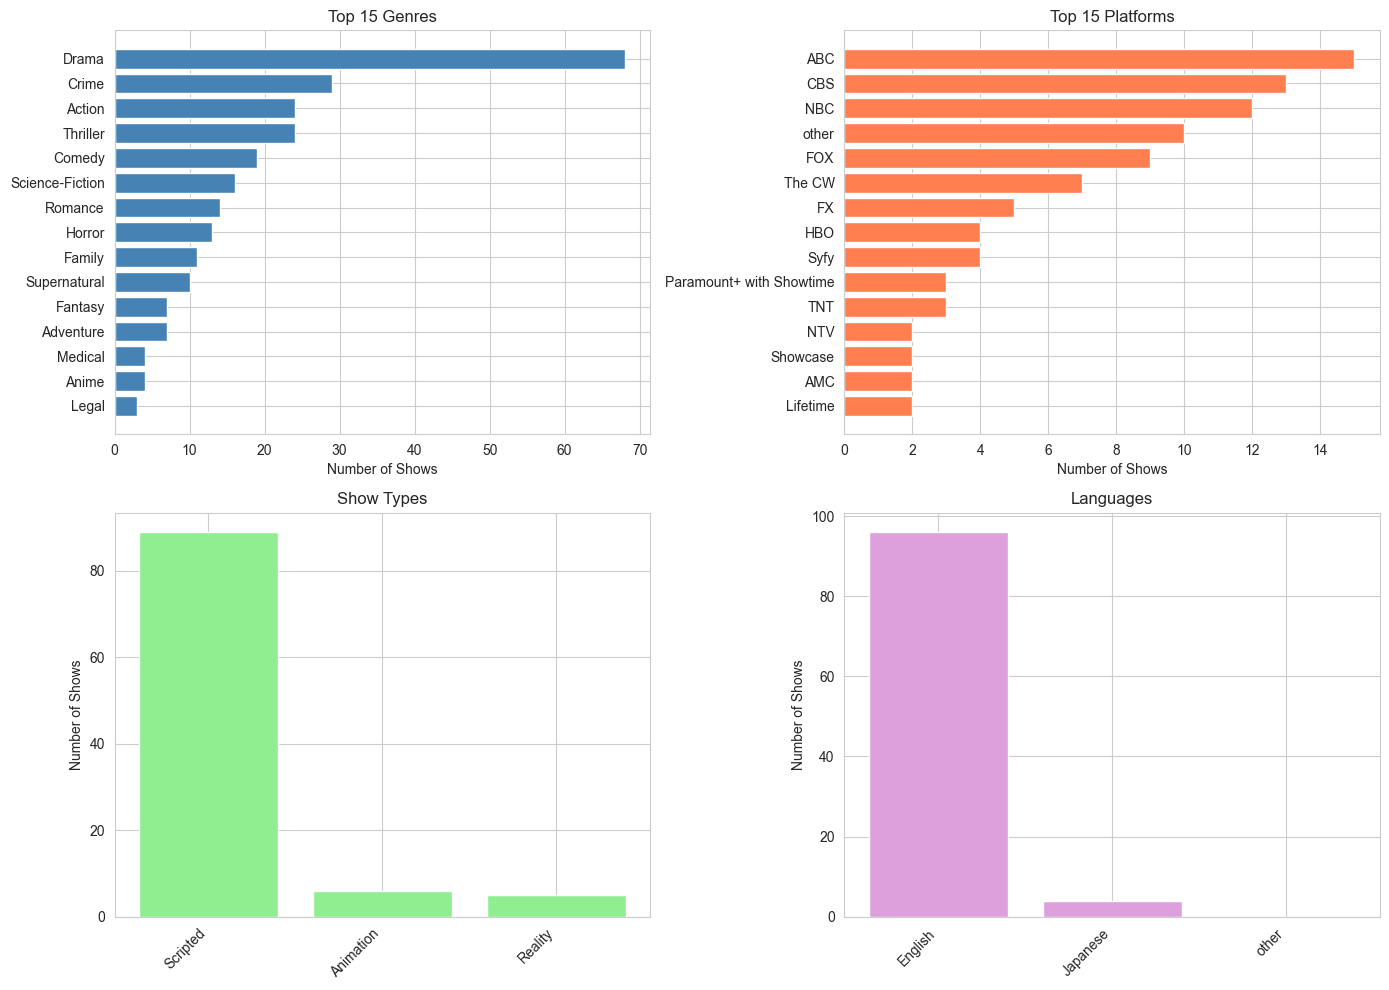

In [14]:
# Cell 13: Visualize feature distributions

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Genre distribution
genre_sums = df_genre_features.sum().sort_values(ascending=False).head(15)
axes[0, 0].barh(range(len(genre_sums)), genre_sums.values, color="steelblue")
axes[0, 0].set_yticks(range(len(genre_sums)))
axes[0, 0].set_yticklabels(genre_sums.index)
axes[0, 0].set_xlabel("Number of Shows")
axes[0, 0].set_title("Top 15 Genres")
axes[0, 0].invert_yaxis()

# Platform distribution
platform_sums = df_platform_features.sum().sort_values(ascending=False).head(15)
axes[0, 1].barh(range(len(platform_sums)), platform_sums.values, color="coral")
axes[0, 1].set_yticks(range(len(platform_sums)))
axes[0, 1].set_yticklabels([col.replace("platform_", "") for col in platform_sums.index])
axes[0, 1].set_xlabel("Number of Shows")
axes[0, 1].set_title("Top 15 Platforms")
axes[0, 1].invert_yaxis()

# Type distribution
type_sums = df_type_features.sum().sort_values(ascending=False)
axes[1, 0].bar(range(len(type_sums)), type_sums.values, color="lightgreen")
axes[1, 0].set_xticks(range(len(type_sums)))
axes[1, 0].set_xticklabels(
    [col.replace("type_", "") for col in type_sums.index], rotation=45, ha="right"
)
axes[1, 0].set_ylabel("Number of Shows")
axes[1, 0].set_title("Show Types")

# Language distribution
lang_sums = df_language_features.sum().sort_values(ascending=False)
axes[1, 1].bar(range(len(lang_sums)), lang_sums.values, color="plum")
axes[1, 1].set_xticks(range(len(lang_sums)))
axes[1, 1].set_xticklabels(
    [col.replace("lang_", "") for col in lang_sums.index], rotation=45, ha="right"
)
axes[1, 1].set_ylabel("Number of Shows")
axes[1, 1].set_title("Languages")

plt.tight_layout()
plt.show()

In [15]:
# Cell 14: Save feature data for next notebook

print("=" * 50)
print("SAVING FEATURES")
print("=" * 50)

# Create processed data directory
processed_dir = project_root / "data" / "processed"
processed_dir.mkdir(parents=True, exist_ok=True)

# Save show metadata
df_clean.to_csv(processed_dir / "shows_metadata.csv", index=False)
print(f"✓ Saved metadata: {processed_dir / 'shows_metadata.csv'}")

# Save feature matrices
np.save(processed_dir / "genre_features.npy", df_genre_features.values)
print("✓ Saved genre features")

# Save text features as sparse matrix (more efficient)
from scipy.sparse import save_npz

save_npz(processed_dir / "text_features.npz", text_features)
print("✓ Saved text features")

np.save(processed_dir / "platform_features.npy", df_platform_features.values)
print("✓ Saved platform features")

np.save(processed_dir / "type_features.npy", df_type_features.values)
print("✓ Saved type features")

np.save(processed_dir / "language_features.npy", df_language_features.values)
print("✓ Saved language features")

# Save the TF-IDF vectorizer and genre encoder for later use
import pickle

with open(processed_dir / "tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)
print("✓ Saved TF-IDF vectorizer")

with open(processed_dir / "genre_encoder.pkl", "wb") as f:
    pickle.dump(mlb_genres, f)
print("✓ Saved genre encoder")

print("\n✓ All features saved successfully!")

SAVING FEATURES
✓ Saved metadata: /Users/trb74/projects/tvbingefriend/tvbingefriend-recommendation-service/data/processed/shows_metadata.csv
✓ Saved genre features
✓ Saved text features
✓ Saved platform features
✓ Saved type features
✓ Saved language features
✓ Saved TF-IDF vectorizer
✓ Saved genre encoder

✓ All features saved successfully!


In [16]:
# Cell 15: Summary

print("=" * 50)
print("FEATURE ENGINEERING COMPLETE")
print("=" * 50)

print(f"\nProcessed {len(df_clean)} shows")
print(f"Total feature dimensions: {combined_features.shape[1]}")
print("\nFeature breakdown:")
print(f"  - Genre features: {df_genre_features.shape[1]} dimensions")
print(f"  - Text features: {text_features_dense.shape[1]} dimensions")
print(f"  - Platform features: {df_platform_features.shape[1]} dimensions")
print(f"  - Type features: {df_type_features.shape[1]} dimensions")
print(f"  - Language features: {df_language_features.shape[1]} dimensions")

print("\nNext steps:")
print("1. Compute content-based similarity (notebook 03)")
print("2. Experiment with different feature weights")
print("3. Evaluate recommendation quality")

FEATURE ENGINEERING COMPLETE

Processed 100 shows
Total feature dimensions: 547

Feature breakdown:
  - Genre features: 20 dimensions
  - Text features: 500 dimensions
  - Platform features: 21 dimensions
  - Type features: 3 dimensions
  - Language features: 3 dimensions

Next steps:
1. Compute content-based similarity (notebook 03)
2. Experiment with different feature weights
3. Evaluate recommendation quality
